<a href="https://colab.research.google.com/github/MiddleSouth/RPGBattleAI/blob/master/RPGTurnBattleWithAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このアプリの使用方法
Git Hubから研究用コードをクローンします

In [1]:
!git clone https://github.com/MiddleSouth/RPGBattleAI.git

Cloning into 'RPGBattleAI'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 1), reused 19 (delta 1), pack-reused 0
Unpacking objects: 100% (19/19), done.


クローンしたフォルダに移動します

In [2]:
%cd RPGBattleAI
!ls -lha

/content/RPGBattleAI
total 40K
drwxr-xr-x 5 root root 4.0K Aug 30 12:47 .
drwxr-xr-x 1 root root 4.0K Aug 30 12:47 ..
drwxr-xr-x 2 root root 4.0K Aug 30 12:47 AIPlayer
drwxr-xr-x 3 root root 4.0K Aug 30 12:47 battle
-rw-r--r-- 1 root root  766 Aug 30 12:47 ExecuteML.py
-rw-r--r-- 1 root root  591 Aug 30 12:47 ExecuteSimulation.py
drwxr-xr-x 8 root root 4.0K Aug 30 12:47 .git
-rw-r--r-- 1 root root   35 Aug 30 12:47 .gitignore
-rw-r--r-- 1 root root 5.0K Aug 30 12:47 RPGTurnBattle.py


深層強化学習（DQN）を用いて、ゲームの学習を行います。

今回は主人公のレベルを7に設定しています。

レベル7の主人公は「敵の呪文を封じる」効果を持つ「封印」の呪文を使えます。魔法の使用率が高い敵に対して「封印」の呪文を有効活用するかが、注目ポイントの一つです。

また、敵キャラの「大ザリガニ」は他の敵と比べて防御力が高いため、攻撃呪文「火の玉」を使うことが有効です。これを有効活用できるかも注目ポイントです。

In [8]:
import sys
import RPGTurnBattle as RPG
from AIPlayer.DQNPlayer import DQNPlayer

training_env = RPG.Simulation(lvs=[7])

player = DQNPlayer(training_env, 100)
player.set_learning_parameters(
    gamma=0.99,
    eps_decay=4000,
    num_episodes=5000,
    batch_size=128,
)
player.training()

end 500 episode
end 1000 episode
end 1500 episode
end 2000 episode
end 2500 episode
end 3000 episode
end 3500 episode
end 4000 episode
end 4500 episode
end 5000 episode
Complete


学習の経過をグラフにプロットします。
過去100エピソードの獲得報酬の移動平均をグラフにしています。

初めのうちはほとんどランダムに行動するため、10回の戦闘を生き残れることはほとんどありません。しかし、3500回頃から10回の戦闘を生き残れる確率が上がり、学習終了時点では高確率で10回の戦闘を生き残れるようになっていることが確認できます。

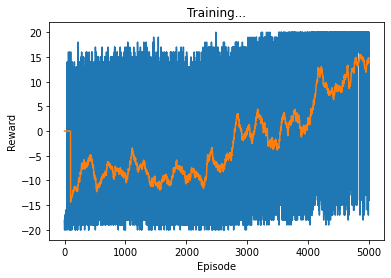

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import torch

plt.figure(2)
plt.clf()
rewards_t = torch.tensor(player.episode_rewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards_t.numpy())
# 過去100エピソードの平均報酬
if len(rewards_t) >= 100:
    means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())
plt.show()

学習後のAIを用いてゲームを100回プレイさせて、学習結果を確認します。
結果からわかることは以下の通りです。

- 約80%の確率で10回の戦闘を生き残っている
- 10回の戦闘を生き残ったパターンのうち、逃走を行ったのはわずか4パターンしかない<br>（敗北リスクが高い場合でも戦闘勝利にこだわっている可能性がある）

21


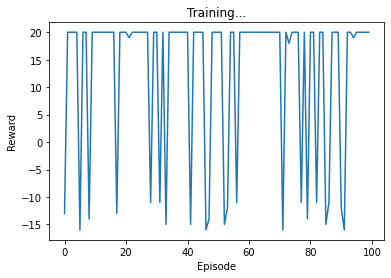

In [10]:
test_env = RPG.Simulation(lvs=[7])
result_rewards, dead_count = player.test(test_env, 100)
print(dead_count)

plt.figure(2)
plt.clf()
rewards_t = torch.tensor(result_rewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards_t.numpy())
plt.show()

学習済みのAIが1エピソード（戦闘10回終了まで）を行う様子を確認してみましょう。

In [11]:
player.test(test_env, 1, True)


あなたのステータス
HP:40, MP:26
モンスター：大ザリガニ

あなた は 火の玉 の呪文を唱えた！ 大ザリガニ に 7 のダメージを与えた！
大ザリガニ の攻撃！ あなた は 1 のダメージを受けた！

あなたのステータス
HP:39, MP:23
モンスター：大ザリガニ

あなた は 火の玉 の呪文を唱えた！ 大ザリガニ に 7 のダメージを与えた！
大ザリガニ の攻撃！ あなた は 1 のダメージを受けた！

あなたのステータス
HP:38, MP:20
モンスター：大ザリガニ

あなた の攻撃！ 大ザリガニ に 6 のダメージを与えた！
大ザリガニ は 倒れた！

大ザリガニ を倒した！
残り戦闘回数： 9 回

新たに 魔法コウモリ が出現しました。コマンドを選択してください。

あなたのステータス
HP:38, MP:20
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 10 のダメージを与えた！
魔法コウモリ は 火の玉 の呪文を唱えた！ あなた は 8 のダメージを受けた！

あなたのステータス
HP:30, MP:20
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 11 のダメージを与えた！
魔法コウモリ は 倒れた！

魔法コウモリ を倒した！
残り戦闘回数： 8 回

新たに 魔法コウモリ が出現しました。コマンドを選択してください。

あなたのステータス
HP:30, MP:20
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 10 のダメージを与えた！
魔法コウモリ の攻撃！ あなた は 0 のダメージを受けた！

あなたのステータス
HP:30, MP:20
モンスター：魔法コウモリ

あなた の攻撃！ 魔法コウモリ に 8 のダメージを与えた！
魔法コウモリ は 倒れた！

魔法コウモリ を倒した！
残り戦闘回数： 7 回

新たに コウモリーマ が出現しました。コマンドを選択してください。

あなたのステータス
HP:30, MP:20
モンスター：コウモリーマ

あなた の攻撃！ コウモリーマ に 5 のダメージを与えた！
コウモリーマ は 火の玉 の呪文を唱えた！ あなた は 6 のダメージを受けた！

あなたのステータス
HP:24, MP:20
モンスター：コウモリー

([-14], 1)

今回は主人公が敗北するパターンでしたが、AIの行動方針が以下の通り読み取れます。

1. 大ザリガニには「火の玉」の呪文を使い、その他の敵には通常攻撃を行っており、攻撃方法を使い分けている
1. 魔法の使用頻度が特に高い「コウモリーマ」に対しても「封印」の呪文を使っていない
1. HPが低くなると「治療」の呪文を使って自身のHPを回復している。<br>ただし最後の敵（魔法幽霊）との闘いでは回復が間に合わずに敗北している。

1に関してはゲーム作成者の意図したとおりにAIが行動しており、ゲームバランス調整/AIの学習ともに成功していると考えられます。

2のAIの行動は意図した通りの行動ではありません。これには以下二つの原因が考えられます。

- ゲームバランス調整が甘く、「封印」の呪文を使うメリットが薄くなっている
- AIが上手く学習できていない

今回はAIがそれなりの確率で10回の戦闘を生き残っているため、「封印」の呪文にそれほどのメリットを感じていない（=ゲームバランス調整が甘い）可能性が高いです。コウモリーマが使用する呪文を強化して再学習することで、原因を突き止められる可能性があります（この資料中では行いません）。

3については、主人公のHPが17の時点で「治療」の呪文を使っていれば敗北を回避できましたが、この判断は熟練者でも難しいです。この状況で主人公が敗北するには以下の条件がそろわなければいけません。

- 魔法幽霊が2回連続で「火の玉」の呪文を使用する
- 2回の「火の玉」どちらも高威力の乱数を引く<br>（火の玉はダメージ幅が3～10。1回のダメージ期待値は6.5）

この結果は、AIが「一般的なプレイヤー」に近い判断をしており、ゲームを熟知した開発者がテストプレイを行うよりも、より実際のプレイに近いテストプレイを行える可能性を示しています（実際にそのように判断するには、もっと多くの戦闘結果を分析する必要があります）。

かなり説明を省略している部分もありますが、以上がアプリの使用方法の一例です。